# 核心思路：学生历史行为特征->分类器->学习风险预警

<h2>构建模型</h2>

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from sklearn.utils import resample
import pandas as pd
import numpy as np


from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from scipy.stats import binned_statistic
import itertools

import os
os.environ['NLS_LANG'] = 'SIMPLIFIED CHINESE_CHINA.UTF8'
pd.set_option('display.max_columns', 500)



In [12]:
df = pd.read_csv('uwide.csv')

<h3>1. 数据预处理</h3>

In [13]:
#Creating the dependent variable class
factor = pd.factorize(df['SEX'])
df.SEX = factor[0]
definitions = factor[1]

df=df.fillna(0)

In [14]:
df.head()

,USERID,BROWSER_COUNT,COURSE_COUNT,COURSE_LAST_ACCESS,COURSE_SUM_VIEW,COURSE_AVG_SCORE,EXAM_AH_SCORE,EXAM_WRITEN_SCORE,EXAM_MIDDLE_SCORE,EXAM_LAB,EXAM_PROGRESS,EXAM_GROUP_SCORE,EXAM_FACE_SCORE,EXAM_ONLINE_SCORE,NODEBB_LAST_POST,NODEBB_CHANNEL_COUNT,NODEBB_TOPIC_COUNT,COURSE_SUM_VIDEO_LEN,SEX,MAJORID,STATUS,GRADE,CLASSID,EXAM_HOMEWORK,EXAM_LABSCORE,EXAM_OTHERSCORE,NODEBB_PARTICIPATIONRATE,COURSE_WORKTIME,COURSE_WORKACCURACYRATE,COURSE_WORKCOMPLETERATE,NODEBB_POSTSCOUNT,NODEBB_NORMALBBSPOSTSCOUONT,NODEBB_REALBBSARCHIVECOUNT,NORMALBBSARCHIVECOUNT,COURSE_WORKCOUNT,STUNO,ID,STUID,COURSEOPENID,HOMEWORKSCORE,WRITTENASSIGNMENTSCORE,MIDDLEASSIGNMENTSCORE,LABSCORE,OTHERSCORE,TOTALSCORE,STUDYTERM,COURSEID,EXAMNUM,PROCESS,GROUPSTUDYSCORE,FACESTUDYSCORE,ONLINESTUDYSCORE
0,310_20178310080783,334.0,11,1.513620e+09,0.000000,0.000000,94.000000,2.727273,1.727273,30.583333,0.0,0.0,10.450000,6.277273,1.510339e+09,2.0,2.0,0.0,0,310_260000256,注册,201703,310_20178310080020,52.454545,20.363636,0,9.290000,5430.428571,67.528571,94.285714,4.428571,0.0,1.571429,0.0,6.571429,20178310080783,t4yzarwohqvdc3a4q-z1zq,310_20178310080783,a0euanqnrrzbdsesy4rymw,38,0,19,0,0,97,201703,310_260000656,"2,7510",0,0,20.0,20.0
1,310_20178310080790,744.0,407,1.513371e+09,0.718819,0.416819,91.454545,2.727273,1.727273,21.350000,0.0,0.0,9.390909,5.713636,1.522433e+09,2.0,2.0,0.0,0,310_260000256,注册,201703,310_20178310080020,51.818182,20.000000,0,6.616667,9636.833333,44.835000,100.000000,4.833333,0.0,1.333333,0.0,8.833333,20178310080790,vekcabgoj5xeaq1wxo-i-a,310_20178310080790,a0euanqnrrzbdsesy4rymw,38,0,19,0,0,94,201703,310_260000656,"2,7510",0,0,17.0,20.0
2,310_20128310060450,17.0,9,1.505817e+09,0.000000,0.000000,54.166667,6.166667,7.500000,0.000000,0.0,0.0,33.233333,7.333333,0.000000e+00,0.0,0.0,0.0,1,310_260000040,注册,201203,310_20128310060088,0.000000,0.000000,0,0.000000,0.000000,38.642857,85.714286,0.000000,0.0,0.000000,0.0,0.571429,20128310060450,n-gtadyo-zncfssre8cqvq,310_20128310060450,a0euanqnrrzbdsesy4rymw,0,0,18,0,0,52,201703,310_260000656,"2,7510",0,0,17.2,17.0
3,310_20128310320840,154.0,133,1.513881e+09,0.021609,0.000000,81.000000,0.000000,17.000000,0.000000,99.0,0.0,15.000000,14.000000,0.000000e+00,0.0,0.0,1867.0,0,310_260000090,注册,201203,310_20128310320099,35.000000,0.000000,0,0.000000,28253.000000,84.140000,100.000000,0.000000,0.0,0.000000,0.0,7.000000,20128310320840,io4sauqoarjm3nhle5p5aa,310_20128310320840,a0euanqnrrzbdsesy4rymw,35,0,17,0,0,81,201703,310_260000656,"2,7510",99,0,15.0,14.0
4,310_20128310320777,50.0,1,1.514159e+09,0.000000,0.000000,67.000000,0.000000,17.000000,0.000000,0.0,0.0,15.000000,14.000000,0.000000e+00,0.0,0.0,0.0,0,310_260000090,注册,201203,310_20128310320099,21.000000,0.000000,0,0.000000,12071.000000,57.200000,100.000000,0.000000,0.0,0.000000,0.0,5.000000,20128310320777,9tl7acmop59oretuqrhvzg,310_20128310320777,a0euanqnrrzbdsesy4rymw,21,0,17,0,0,67,201703,310_260000656,"2,7510",0,0,15.0,14.0


In [15]:
#Detect null values
null_columns=df.columns[df.isnull().any()]
print(df[df.isnull().any(axis=1)][null_columns].head())


Empty DataFrame
Columns: []
Index: []


<h3>3. 选择特征列</h3>

In [16]:
df['SState'] = np.where(df['TOTALSCORE']>60, 0, 1)

df.head()


,USERID,BROWSER_COUNT,COURSE_COUNT,COURSE_LAST_ACCESS,COURSE_SUM_VIEW,COURSE_AVG_SCORE,EXAM_AH_SCORE,EXAM_WRITEN_SCORE,EXAM_MIDDLE_SCORE,EXAM_LAB,EXAM_PROGRESS,EXAM_GROUP_SCORE,EXAM_FACE_SCORE,EXAM_ONLINE_SCORE,NODEBB_LAST_POST,NODEBB_CHANNEL_COUNT,NODEBB_TOPIC_COUNT,COURSE_SUM_VIDEO_LEN,SEX,MAJORID,STATUS,GRADE,CLASSID,EXAM_HOMEWORK,EXAM_LABSCORE,EXAM_OTHERSCORE,NODEBB_PARTICIPATIONRATE,COURSE_WORKTIME,COURSE_WORKACCURACYRATE,COURSE_WORKCOMPLETERATE,NODEBB_POSTSCOUNT,NODEBB_NORMALBBSPOSTSCOUONT,NODEBB_REALBBSARCHIVECOUNT,NORMALBBSARCHIVECOUNT,COURSE_WORKCOUNT,STUNO,ID,STUID,COURSEOPENID,HOMEWORKSCORE,WRITTENASSIGNMENTSCORE,MIDDLEASSIGNMENTSCORE,LABSCORE,OTHERSCORE,TOTALSCORE,STUDYTERM,COURSEID,EXAMNUM,PROCESS,GROUPSTUDYSCORE,FACESTUDYSCORE,ONLINESTUDYSCORE,SState
0,310_20178310080783,334.0,11,1.513620e+09,0.000000,0.000000,94.000000,2.727273,1.727273,30.583333,0.0,0.0,10.450000,6.277273,1.510339e+09,2.0,2.0,0.0,0,310_260000256,注册,201703,310_20178310080020,52.454545,20.363636,0,9.290000,5430.428571,67.528571,94.285714,4.428571,0.0,1.571429,0.0,6.571429,20178310080783,t4yzarwohqvdc3a4q-z1zq,310_20178310080783,a0euanqnrrzbdsesy4rymw,38,0,19,0,0,97,201703,310_260000656,"2,7510",0,0,20.0,20.0,0
1,310_20178310080790,744.0,407,1.513371e+09,0.718819,0.416819,91.454545,2.727273,1.727273,21.350000,0.0,0.0,9.390909,5.713636,1.522433e+09,2.0,2.0,0.0,0,310_260000256,注册,201703,310_20178310080020,51.818182,20.000000,0,6.616667,9636.833333,44.835000,100.000000,4.833333,0.0,1.333333,0.0,8.833333,20178310080790,vekcabgoj5xeaq1wxo-i-a,310_20178310080790,a0euanqnrrzbdsesy4rymw,38,0,19,0,0,94,201703,310_260000656,"2,7510",0,0,17.0,20.0,0
2,310_20128310060450,17.0,9,1.505817e+09,0.000000,0.000000,54.166667,6.166667,7.500000,0.000000,0.0,0.0,33.233333,7.333333,0.000000e+00,0.0,0.0,0.0,1,310_260000040,注册,201203,310_20128310060088,0.000000,0.000000,0,0.000000,0.000000,38.642857,85.714286,0.000000,0.0,0.000000,0.0,0.571429,20128310060450,n-gtadyo-zncfssre8cqvq,310_20128310060450,a0euanqnrrzbdsesy4rymw,0,0,18,0,0,52,201703,310_260000656,"2,7510",0,0,17.2,17.0,1
3,310_20128310320840,154.0,133,1.513881e+09,0.021609,0.000000,81.000000,0.000000,17.000000,0.000000,99.0,0.0,15.000000,14.000000,0.000000e+00,0.0,0.0,1867.0,0,310_260000090,注册,201203,310_20128310320099,35.000000,0.000000,0,0.000000,28253.000000,84.140000,100.000000,0.000000,0.0,0.000000,0.0,7.000000,20128310320840,io4sauqoarjm3nhle5p5aa,310_20128310320840,a0euanqnrrzbdsesy4rymw,35,0,17,0,0,81,201703,310_260000656,"2,7510",99,0,15.0,14.0,0
4,310_20128310320777,50.0,1,1.514159e+09,0.000000,0.000000,67.000000,0.000000,17.000000,0.000000,0.0,0.0,15.000000,14.000000,0.000000e+00,0.0,0.0,0.0,0,310_260000090,注册,201203,310_20128310320099,21.000000,0.000000,0,0.000000,12071.000000,57.200000,100.000000,0.000000,0.0,0.000000,0.0,5.000000,20128310320777,9tl7acmop59oretuqrhvzg,310_20128310320777,a0euanqnrrzbdsesy4rymw,21,0,17,0,0,67,201703,310_260000656,"2,7510",0,0,15.0,14.0,0


In [17]:
cols = df.columns.tolist()
df = df[[
#'USERID',
 'BROWSER_COUNT',
 'COURSE_COUNT',
#  'COURSE_LAST_ACCESS',
 'COURSE_SUM_VIEW',
 'COURSE_AVG_SCORE',
 'EXAM_AH_SCORE',
 'EXAM_WRITEN_SCORE',
 'EXAM_MIDDLE_SCORE',
 'EXAM_LAB',
 'EXAM_PROGRESS',
 'EXAM_GROUP_SCORE',
 'EXAM_FACE_SCORE',
 'EXAM_ONLINE_SCORE',
#  'NODEBB_LAST_POST',
 'NODEBB_CHANNEL_COUNT',
 'NODEBB_TOPIC_COUNT',
 'COURSE_SUM_VIDEO_LEN',
 'SEX',
#  'MAJORID',
#  'STATUS',
#  'GRADE',
#  'CLASSID',
 'EXAM_HOMEWORK',
 'EXAM_LABSCORE',
 'EXAM_OTHERSCORE',
 'NODEBB_PARTICIPATIONRATE',
 'COURSE_WORKTIME',
 'COURSE_WORKACCURACYRATE',
 'COURSE_WORKCOMPLETERATE',
 'NODEBB_POSTSCOUNT',
 'NODEBB_NORMALBBSPOSTSCOUONT',
 'NODEBB_REALBBSARCHIVECOUNT',
 'NORMALBBSARCHIVECOUNT',
 'COURSE_WORKCOUNT',
#  'STUNO',
#  'ID',
#  'STUID',
#  'COURSEOPENID',
#  'HOMEWORKSCORE',
#  'WRITTENASSIGNMENTSCORE',
#  'MIDDLEASSIGNMENTSCORE',
#  'LABSCORE',
#  'OTHERSCORE',
 'SState',
#  'STUDYTERM',
#  'COURSEID',
#  'EXAMNUM',
#  'PROCESS',
#  'GROUPSTUDYSCORE',
#  'FACESTUDYSCORE',
#  'ONLINESTUDYSCORE'
]]
print(df.columns.tolist())



['BROWSER_COUNT', 'COURSE_COUNT', 'COURSE_SUM_VIEW', 'COURSE_AVG_SCORE', 'EXAM_AH_SCORE', 'EXAM_WRITEN_SCORE', 'EXAM_MIDDLE_SCORE', 'EXAM_LAB', 'EXAM_PROGRESS', 'EXAM_GROUP_SCORE', 'EXAM_FACE_SCORE', 'EXAM_ONLINE_SCORE', 'NODEBB_CHANNEL_COUNT', 'NODEBB_TOPIC_COUNT', 'COURSE_SUM_VIDEO_LEN', 'SEX', 'EXAM_HOMEWORK', 'EXAM_LABSCORE', 'EXAM_OTHERSCORE', 'NODEBB_PARTICIPATIONRATE', 'COURSE_WORKTIME', 'COURSE_WORKACCURACYRATE', 'COURSE_WORKCOMPLETERATE', 'NODEBB_POSTSCOUNT', 'NODEBB_NORMALBBSPOSTSCOUONT', 'NODEBB_REALBBSARCHIVECOUNT', 'NORMALBBSARCHIVECOUNT', 'COURSE_WORKCOUNT', 'SState']


In [18]:
len(df.columns.tolist())

29

In [19]:
df.SState.value_counts()

0    1801
1     205
Name: SState, dtype: int64

<h3>4. 处理数据不平衡</h3>

In [20]:

#二分类平衡
df_majority = df[df.SState==0]
df_minority = df[df.SState==1]

df_majority_downsampled = df_majority
# Downsample majority class
print(len(df_majority))
print(len(df_minority))
if len(df_majority)>len(df_minority)*10:
    print("downsample majority 1 class")
    new_majority_count = len(df_minority)*10
    df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=new_majority_count,     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df = pd.concat([df_majority_downsampled, df_minority])


1801
205


In [21]:
df.SState.value_counts()

0    1801
1     205
Name: SState, dtype: int64

<h3>5. 构建模型及训练</h3>

In [24]:
#Splitting the data into independent and dependent variables
X = df.iloc[:,0:len(df.columns.tolist())-1].values
y = df.iloc[:,len(df.columns.tolist())-1].values


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 21)

from collections import Counter


from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)#
print('Original dataset shape %s' % Counter(y_train))
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

X_train = X_res
y_train = y_res


Original dataset shape Counter({0: 1266, 1: 138})
Resampled dataset shape Counter({0: 1266, 1: 1266})


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:

param_grid = {
#     'min_samples_split': [2, 3, 5, 10],
    'min_samples_split': range(2, 10),
    'n_estimators' : [10,50,100,150],
    'max_depth': [5, 10,15,20],
    'max_features': [5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}



In [28]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(criterion = 'entropy', oob_score=True,random_state = 42)


In [29]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=5)
    grid_search = GridSearchCV(classifier, param_grid, refit=refit_score,
                           cv=skf, return_train_score=True,scoring=scorers, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search



In [30]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')



Best params for recall_score
{'max_depth': 15, 'max_features': 5, 'min_samples_split': 3, 'n_estimators': 150}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       514        21
pos        13        54


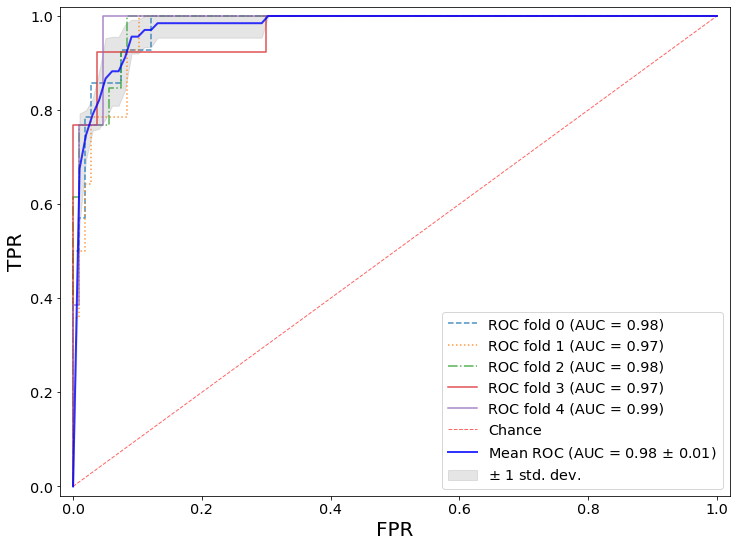

In [31]:
from scipy import interp

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)



tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

skf = StratifiedKFold(n_splits=5)
linetypes = ['--',':','-.','-','-','O']

i = 0
for train, test in skf.split(X_test, y_test):
    probas_ = grid_search_clf.predict_proba(X_test[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1.5,linestyle = linetypes[i], alpha=0.8,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
         label='Chance', alpha=.6)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('FPR',fontsize=20)
plt.ylabel('TPR',fontsize=20)
# plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


In [32]:
grid_search_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=15, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


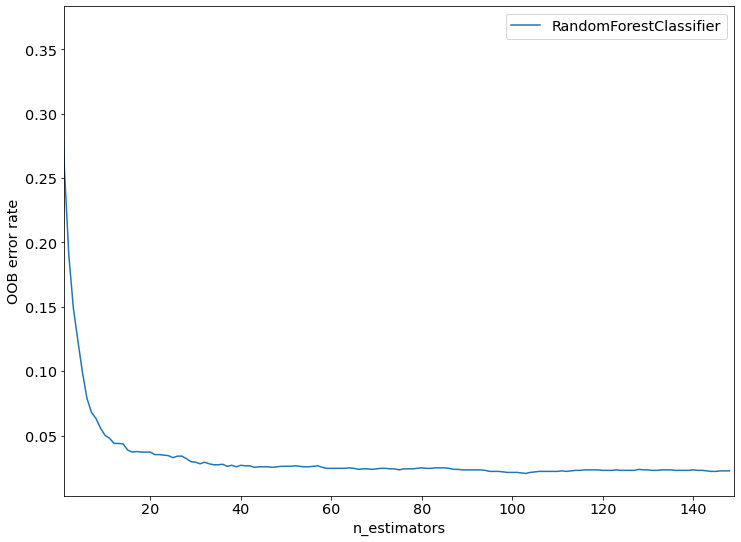

In [33]:
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.


# Range of `n_estimators` values to explore.
min_estimators = 1
max_estimators = 149
clf = grid_search_clf.best_estimator_
errs = []
for i in range(min_estimators, max_estimators + 1):
    clf.set_params(n_estimators=i)
    clf.fit(X_train, y_train)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - clf.oob_score_
    errs.append(oob_error)

plt.plot(errs,label='RandomForestClassifier')

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

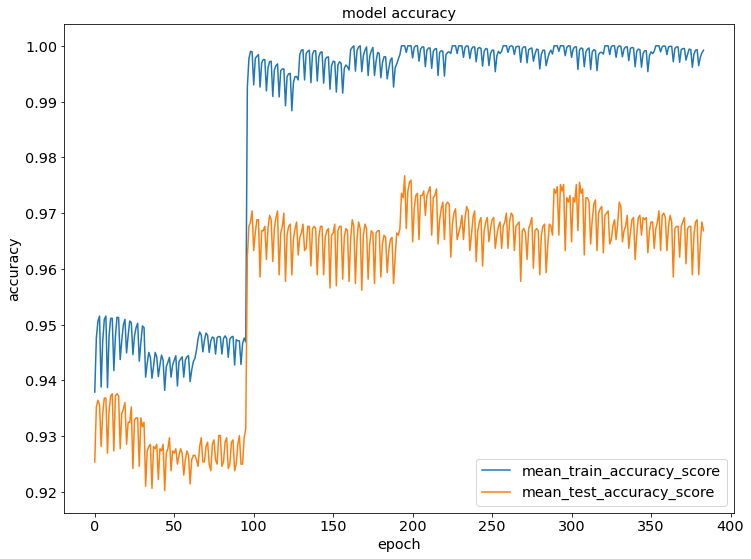

In [34]:
results = grid_search_clf.cv_results_

# plt.plot(results['split0_train_recall_score'])
# plt.plot(results['split1_train_recall_score'])
# plt.plot(results['split2_train_recall_score'])

# plt.plot(results['split0_test_recall_score'])
# plt.plot(results['split1_test_recall_score'])
# plt.plot(results['split2_test_recall_score'])
# print(len(results['mean_train_accuracy_score']))
plt.plot(results['mean_train_accuracy_score'])
plt.plot(results['mean_test_accuracy_score'])


# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['mean_train_accuracy_score', 'mean_test_accuracy_score'], loc='lower right')


plt.show()


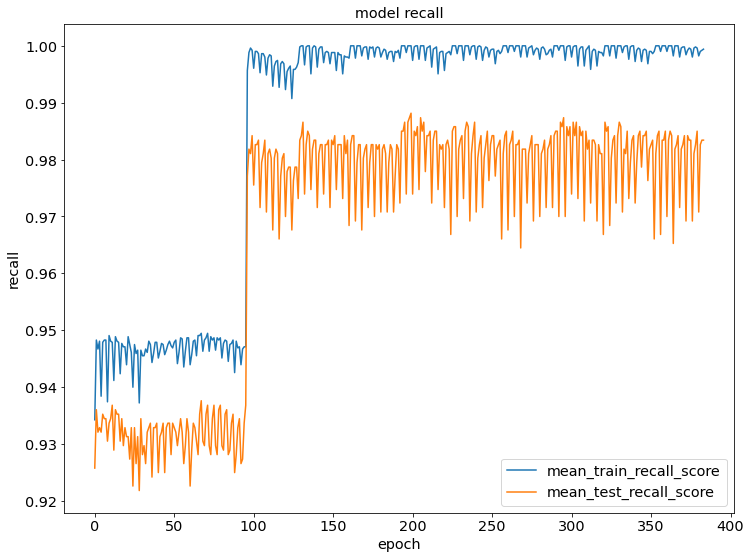

In [35]:
results = grid_search_clf.cv_results_

# plt.plot(results['split0_train_recall_score'])
# plt.plot(results['split1_train_recall_score'])
# plt.plot(results['split2_train_recall_score'])

# plt.plot(results['split0_test_recall_score'])
# plt.plot(results['split1_test_recall_score'])
# plt.plot(results['split2_test_recall_score'])
# print(len(results['mean_train_accuracy_score']))

plt.plot(results['mean_train_recall_score'])
plt.plot(results['mean_test_recall_score'])



plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
# plt.legend(['split0_train_recall_score', 'split1_train_recall_score','split2_train_recall_score',
#            'split0_test_recall_score', 'split1_test_recall_score','split2_test_recall_score'], loc='lower right')

plt.legend(['mean_train_recall_score','mean_test_recall_score'], loc='lower right')


plt.show()


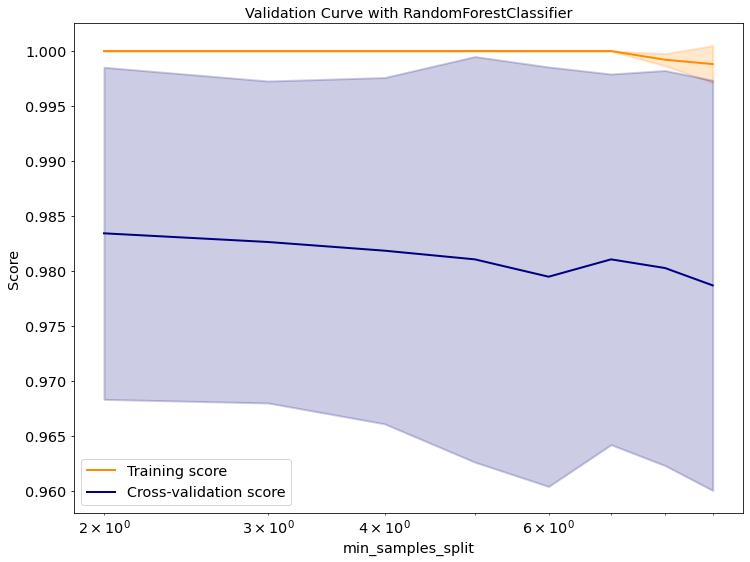

In [36]:
from sklearn.model_selection import validation_curve
param_range = range(2,10)
train_scores, test_scores = validation_curve(grid_search_clf.best_estimator_, X_train, y_train,'min_samples_split',param_range,
                                              cv=3,scoring="recall", n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel("min_samples_split")
plt.ylabel("Score")
# plt.ylim(0.96, 1.01)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

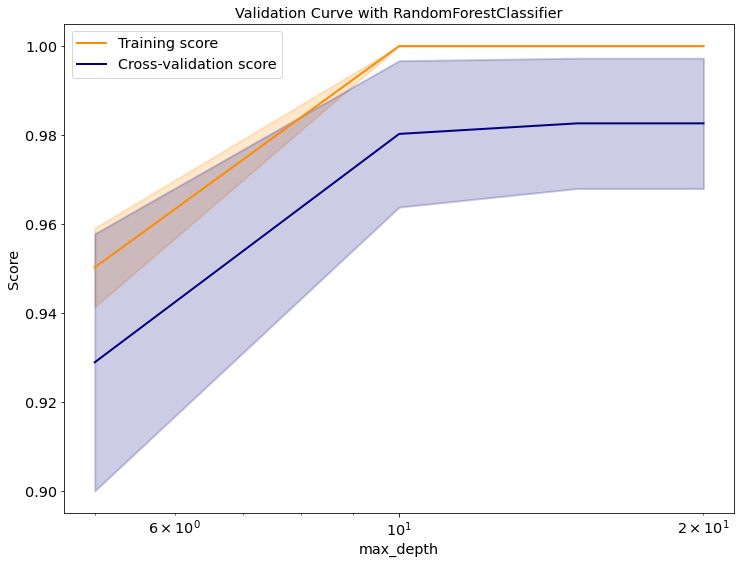

In [37]:
from sklearn.model_selection import validation_curve
param_range = [5, 10, 15, 20]
train_scores, test_scores = validation_curve(grid_search_clf.best_estimator_, X_train, y_train,'max_depth',param_range,
                                              cv=3,scoring="recall", n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel("max_depth")
plt.ylabel("Score")
# plt.ylim(0.96, 1.01)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

<h3>6. 模型验证及检测</h3>

In [38]:
# Predicting the Test set results
y_pred = grid_search_clf.predict(X_test)
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted    0   1
Actual            
0          514  21
1           13  54


In [39]:
import sklearn
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

print(sklearn.metrics.roc_auc_score(y_test, grid_search_clf.predict_proba(X_test)[:,1]))
print(sklearn.metrics.f1_score(y_test, y_pred))

0.9435215946843853
0.8059701492537313
0.9766913098061096
0.7605633802816901


In [40]:
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))


Predicted    0   1
Actual            
0          513  22
1           16  51
0.9368770764119602
0.7611940298507462


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Feature importance ranking:
1. feature 4 (0.216478)
2. feature 27 (0.093093)
3. feature 6 (0.071598)
4. feature 16 (0.069556)
5. feature 20 (0.064696)
6. feature 0 (0.053872)
7. feature 11 (0.044606)
8. feature 5 (0.038150)
9. feature 25 (0.034136)
10. feature 15 (0.033280)
11. feature 17 (0.033060)
12. feature 9 (0.026103)
13. feature 22 (0.025245)
14. feature 23 (0.024964)
15. feature 19 (0.023626)
16. feature 1 (0.022157)
17. feature 21 (0.021801)
18. feature 7 (0.021237)
19. feature 10 (0.020546)
20. feature 8 (0.015013)
21. feature 12 (0.014578)
22. feature 14 (0.011616)
23. feature 2 (0.010837)
24. feature 13 (0.007819)
25. feature 3 (0.001933)
26. feature 24 (0.000000)
27. feature 26 (0.000000)
28. feature 18 (0.000000)


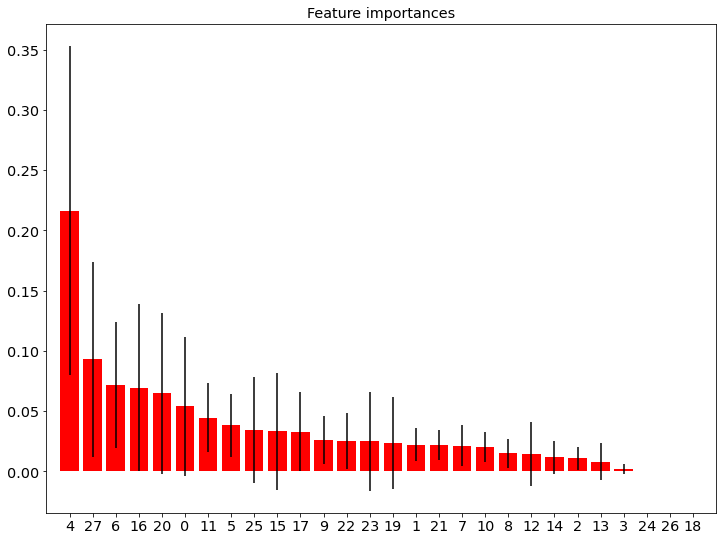

In [41]:
classifier = grid_search_clf.best_estimator_

importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature importance ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()


In [42]:
result_importances = list(zip(df.columns[0:len(df.columns.tolist())-1], classifier.feature_importances_))
result_importances.sort(key=lambda x: x[1])
result_importances

[('EXAM_OTHERSCORE', 0.0),
 ('NODEBB_NORMALBBSPOSTSCOUONT', 0.0),
 ('NORMALBBSARCHIVECOUNT', 0.0),
 ('COURSE_AVG_SCORE', 0.0019328456624900887),
 ('NODEBB_TOPIC_COUNT', 0.007819009708536799),
 ('COURSE_SUM_VIEW', 0.010837280420017477),
 ('COURSE_SUM_VIDEO_LEN', 0.011615804763736366),
 ('NODEBB_CHANNEL_COUNT', 0.014578221453437545),
 ('EXAM_PROGRESS', 0.015012904191942093),
 ('EXAM_FACE_SCORE', 0.02054623851825048),
 ('EXAM_LAB', 0.021237009860476722),
 ('COURSE_WORKACCURACYRATE', 0.021800786778466388),
 ('COURSE_COUNT', 0.022156608726925035),
 ('NODEBB_PARTICIPATIONRATE', 0.023626105557572243),
 ('NODEBB_POSTSCOUNT', 0.02496419298018662),
 ('COURSE_WORKCOMPLETERATE', 0.025244955960106643),
 ('EXAM_GROUP_SCORE', 0.026102919256331847),
 ('EXAM_LABSCORE', 0.03305993689487798),
 ('SEX', 0.03327988243339489),
 ('NODEBB_REALBBSARCHIVECOUNT', 0.034135703043772676),
 ('EXAM_WRITEN_SCORE', 0.038150334965403335),
 ('EXAM_ONLINE_SCORE', 0.044605657862183054),
 ('BROWSER_COUNT', 0.0538718129166997

最重要的特征：课程实践平均成绩，形考成绩，作业答题数、浏览次数等

In [43]:
joblib.dump(classifier, 'randomforestmodel.pkl') 

['randomforestmodel.pkl']

<h3>7. 对比其它模型</h3>

7.1 与SVM算法比较

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
No handles with labels found to put in legend.


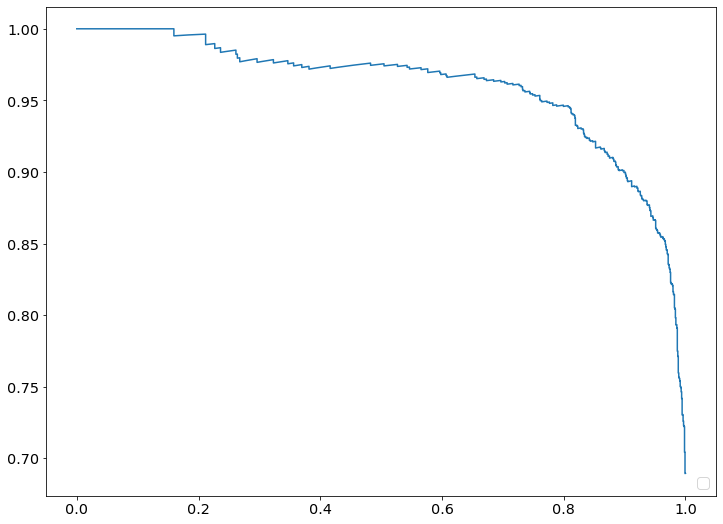

In [44]:
import sklearn.svm
import sklearn.metrics
from matplotlib import pyplot as plt

clf = sklearn.svm.LinearSVC().fit(X_train, y_train)
decision_values = clf.decision_function(X_train)

precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_train, decision_values)

plt.plot(recall, precision)
plt.legend(loc="lower right")
plt.show()

In [45]:
y_pred = clf.predict(X_test)
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

print(sklearn.metrics.roc_auc_score(y_test, y_pred))
print(sklearn.metrics.f1_score(y_test, y_pred))

Predicted    0   1
Actual            
0          482  53
1           12  55
0.8920265780730897
0.8208955223880597
0.860915050913656
0.6285714285714286


In [46]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

# print(sklearn.metrics.roc_auc_score(y_test, y_pred))
print(sklearn.metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


print(sklearn.metrics.f1_score(y_test, y_pred))

0.8920265780730897
0.835820895522388
0.9386246338401452
0.6327683615819208


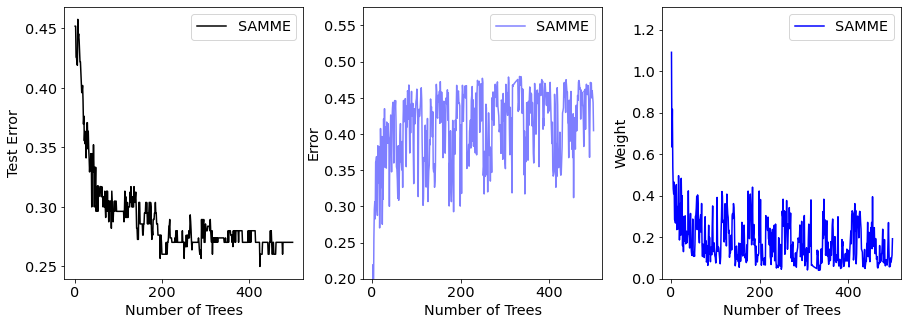

In [48]:
from sklearn.externals.six.moves import zip

import matplotlib.pyplot as plt

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier



bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=3),
    n_estimators=500,
    learning_rate=.5,
    algorithm="SAMME")

bdt_discrete.fit(X_train, y_train)

discrete_test_errors = []


for discrete_train_predict in bdt_discrete.staged_predict(X_test):
    discrete_test_errors.append(1. - recall_score(discrete_train_predict, y_test))

n_trees_discrete = len(bdt_discrete)

# Boosting might terminate early, but the following arrays are always
# n_estimators long. We crop them to the actual number of trees here:
discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(1, n_trees_discrete + 1),
         discrete_test_errors, c='black', label='SAMME')
plt.legend()
# plt.ylim(0.18, 0.62)
plt.ylabel('Test Error')
plt.xlabel('Number of Trees')

plt.subplot(132)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_errors,
         "b", label='SAMME', alpha=.5)
plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.ylim((.2,discrete_estimator_errors.max() * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights,
         "b", label='SAMME')
plt.legend()
plt.ylabel('Weight')
plt.xlabel('Number of Trees')
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-20, n_trees_discrete + 20))

# prevent overlapping y-axis labels
plt.subplots_adjust(wspace=0.25)
plt.show()

In [49]:

y_pred = bdt_discrete.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

# print(sklearn.metrics.roc_auc_score(y_test, y_pred))
print(sklearn.metrics.roc_auc_score(y_test, bdt_discrete.predict_proba(X_test)[:,1]))


print(sklearn.metrics.f1_score(y_test, y_pred))

0.9451827242524917
0.8059701492537313
0.9752824661738039
0.7659574468085106
